In [3]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules

def household_guess(a_grid,e_grid,r,w,gamma):
    wel = (1+r)*a_grid[np.newaxis,:] + w*e_grid[:,np.newaxis]
    V_prime = (1+r)*(wel/2)**(-gamma)
    return V_prime

# Important: V_prime MUST be named v_prime_p in the argument of the function! Otherwise, raises error

@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init=household_guess)
def household(V_prime_p,a_grid,e_grid,r,w,beta,gamma):
    c_prime = (beta*V_prime_p)**(-1/gamma)
    new_grid = c_prime + a_grid
    wel = (1+r)*a_grid[np.newaxis,:] + w*e_grid[:,np.newaxis]

    a = interpolate.interpolate_y(new_grid,wel,a_grid)
    misc.setmin(a,a_grid[0])
    c = wel - a
    V_prime= (1+r)*c**(-gamma)

    return V_prime,a,c

print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

<HetBlock 'household'>
Inputs: ['a_grid', 'e_grid', 'r', 'w', 'beta', 'gamma', 'Pi']
Macro outputs: ['A', 'C']
Micro outputs: ['D', 'Dbeg', 'Pi', 'V_prime', 'a', 'c']


In [4]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid


household_ext = household.add_hetinputs([make_grid])

print(household_ext)
print(f'Inputs: {household_ext.inputs}')

<HetBlock 'household' with hetinput 'make_grid'>
Inputs: ['r', 'w', 'beta', 'gamma', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA']


In [5]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y


@simple
def mkt_clearing(K, A, Y, C, delta):
    asset_mkt = A - K
    goods_mkt = Y - C - delta * K
    return asset_mkt, goods_mkt

ks = create_model([household_ext, firm, mkt_clearing], name="Krusell-Smith")
print(ks.inputs)

['beta', 'gamma', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'K', 'L', 'Z', 'alpha', 'delta']


In [6]:

calibration = {'gamma': 1, 'delta': 0.025, 'alpha': 0.11, 'rho_e': 0.966, 'sd_e': 0.5, 'L': 1.0,
               'nE': 7, 'nA': 500, 'amin': 0, 'amax': 200}
unknowns_ss = {'beta': 0.98, 'Z': 0.85, 'K': 3.}
targets_ss = {'r': 0.01, 'Y': 1., 'asset_mkt': 0.}

ss = ks.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='hybr')

print(ss)

<SteadyStateDict: ['gamma', 'delta', 'alpha', 'rho_e', 'sd_e', 'L', 'nE', 'nA', 'amin', 'amax', 'beta', 'Z', 'K', 'r', 'w', 'Y', 'A', 'C', 'asset_mkt', 'goods_mkt'], internals=['household']>


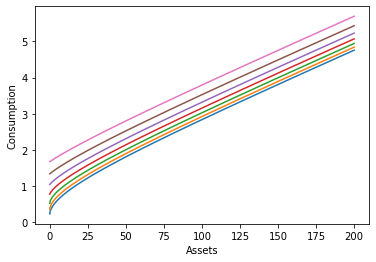

In [7]:
plt.plot(ss.internals['household']['a_grid'], ss.internals['household']['c'].T)
plt.xlabel('Assets'), plt.ylabel('Consumption')
plt.show()

In [8]:
asset_grid = grids.agrid(amin = 0.1,amax = 5,n = 100)
e_grid, _, Pi = grids.markov_rouwenhorst(rho=0.8, sigma=1, N=4)

In [41]:
def bissection_onestep(f,a,b):
    if not np.all(f(a)*f(b) <= 0):
        raise ValueError("No sign change")
    else:
        mid_point = (a + b)/2
        mid_value = f(mid_point)
        new_a = a
        new_b = b
        indxs_a = np.nonzero(mid_value*f(b) <= 0)
        indxs_b = np.nonzero(mid_value*f(a) <= 0)
        if indxs_a[0].size != 0 and indxs_a[1].size != 0:
            new_a[indxs_a[0],indxs_a[1]] = mid_point[indxs_a[0],indxs_a[1]]
        if indxs_b[0].size != 0 and indxs_b[1].size != 0:
            new_b[indxs_b[0],indxs_b[1]] = mid_point[indxs_b[0],indxs_b[1]]
        return new_a,new_b

In [42]:
def vec_bissection(f,a,b,iter_max = 100,tol = 1E-11):
    i = 1
    err = 1
    while i < iter_max and err > tol:
        a,b = bissection_onestep(f,a,b)
        err = np.max(np.abs(a - b))
        i += 1
    return a,b,i

In [43]:
def solve_household(c,we,rest,gamma,v,phi):
    return c - we*(we/(-phi*c**gamma))**(1/v) - rest

In [69]:
def household_guess(a_grid,e_grid,r,w,gamma):
    wel = (1+r)*a_grid[np.newaxis,:] + w*e_grid[:,np.newaxis]
    V_prime = (1+r)*(wel/2)**(-gamma)
    return V_prime

def consumption(c,we,rest,gamma,v,phi):
    return c - we*(we/(-phi*c**gamma))**(1/v) - rest

# Important: V_prime MUST be named v_prime_p in the argument of the function! Otherwise, raises error
def household(V_prime_p,a_grid,e_grid,r,w,beta,gamma,v,phi):

    we = w*e_grid[:,np.newaxis]

    c_prime = (beta*V_prime_p)**(-1/gamma) #c_prime is quite a misnomer, since this is the new guess for c_t
    n_prime = (we/(phi*c_prime**gamma))**(1/v)

    new_grid = c_prime + a_grid[np.newaxis,:] - we
    wel = (1+r)*a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)
    n = interpolate.interpolate_y(new_grid,wel,n_prime)

    a = wel + we*n - c
    V_prime= (1+r)*c**(-gamma)

    # checks for violations of the condition of minimal assets required and fixes it

    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    a[indexes_asset] = a_grid[0]

    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:

        aa = np.zeros((indexes_asset[0].size,indexes_asset[1].size))
        bb = c_prime[indexes_asset[0],indexes_asset[1]]

        rest = -a_grid[0] + wel[indexes_asset[1]]
        c[indexes_asset] = vec_bissection(lambda c : consumption(c,we[indexes_asset[0]],rest,gamma,v,phi),aa,bb)
        V_prime[indexes_asset] = (1+r)*c**(gamma)

    return V_prime,a,c

In [72]:
r = 0.1
w = 1
gamma = 1
beta = 1/(1+r)
v = 1
phi = 1
V_start = household_guess(asset_grid,e_grid,r,w,gamma)

In [73]:
household(V_start,asset_grid,e_grid,r,w,beta,gamma,v,phi)

(array([[9.68267957, 9.31788873, 8.97133893, 8.64179589, 8.32813341,
         8.02932181, 7.74441781, 7.47255559, 7.21293905, 6.96483489,
         6.72756655, 6.50050879, 6.28308296, 6.07475268, 5.87502007,
         5.68342236, 5.49952883, 5.32293807, 5.15327558, 4.99019146,
         4.83335851, 4.68247035, 4.53723983, 4.39739752, 4.26269037,
         4.13288047, 4.00774398, 3.88707003, 3.77065986, 3.65832593,
         3.54989113, 3.44518811, 3.34405857, 3.24635266, 3.15192845,
         3.06065142, 2.97239394, 2.88703486, 2.80445912, 2.72455735,
         2.64722553, 2.57236466, 2.49988049, 2.42968321, 2.3616872 ,
         2.2958108 , 2.23197606, 2.17010858, 2.11013726, 2.05199414,
         1.99561426, 1.94093543, 1.88789816, 1.83644547, 1.78652276,
         1.73807773, 1.69106019, 1.64542205, 1.60111713, 1.5581011 ,
         1.5163314 , 1.47576713, 1.43636901, 1.39809926, 1.36092154,
         1.3248009 , 1.28970372, 1.25559762, 1.22245141, 1.19023508,
         1.15891969, 1.12847736, 1